In [1]:
import requests
import pandas as pd
import duckdb
import timeit

from lib_descriptive import plot_battery_arbitrage, plot_battery_arbitrage_multiple, plot_PSA_exec_time
from lib_prescriptive import battery_arbitrage, battery_arbitrage_multiple

In [2]:
# Number of days to query
start_date = '2024-06-05'
experiment_results = []

In [4]:
def retrieve_future_prices():
    con = duckdb.connect('database.db')
    result = con.execute('SELECT * FROM information_schema.tables WHERE table_name = \'future_prices\'')
    table_exists = len(result.fetchdf()) > 0

    if not table_exists:
        # Fetch data from Energinet data portal (since 2020-01-01)
        url = 'https://api.energidataservice.dk/dataset/Elspotprices?offset=0&start=2020-01-01T00:00&end=2024-12-08T00:00&filter=%7B%22PriceArea%22:[%22DK1%22]%7D&sort=HourUTC%20DESC'
        response = requests.get(url)
        result = response.json()
        data = result.get('records', [])

        # Convert data to pandas DataFrame
        df = pd.DataFrame(data)
        df['HourDK'] = pd.to_datetime(df['HourDK'])
        df['PriceArea'] = df['PriceArea'].astype('category')
        df['SpotPriceDKK'] = df['SpotPriceDKK'].astype('float')

        # Store data in parquet file using DuckDB
        con.register('future_prices_vitual', df)
        con.execute('CREATE TABLE future_prices AS SELECT * FROM future_prices_vitual')

    # Load the future predicted prices from the database
    result = con.execute('SELECT * FROM future_prices')
    future_df = result.fetchdf()

    con.close()

    return future_df


In [5]:
def prescribe(number_of_days, number_of_batteries):
    future_df = pd.DataFrame()
    future_df = retrieve_future_prices()

    future_df = future_df[future_df['HourDK'] >= start_date]
    future_df = future_df[future_df['HourDK'] < pd.to_datetime(start_date) + pd.DateOffset(days=number_of_days)]

    future_df['HourDK'] = pd.to_datetime(future_df['HourDK'])
    future_df.set_index('HourDK', inplace=True)
    future_prices = future_df['SpotPriceEUR'].values

    optimal_profit, optimal_schedule, soc_schedule = battery_arbitrage_multiple(future_prices, num_days=number_of_days, num_batteries=number_of_batteries)

    # plot_battery_arbitrage_multiple(future_prices, soc_schedule, optimal_schedule, num_batteries=number_of_batteries)


for i,j in [(1,1), (1,2), (1,3), (7,1), (7,2), (7,3), (30,1), (30,2), (30,3), (60, 1), (60, 2), (60, 3)]:
    execution_time = timeit.timeit(
        stmt="prescribe(days, batteries)",
        setup=f"from __main__ import prescribe, start_date, retrieve_future_prices, battery_arbitrage_multiple; days = {i}; batteries = {j}",
        number=1
    )
    experiment_results.append({ "days": i, "batteries": j, "exec_time": execution_time})

                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 11 05:41:32 PM: Your problem has 96 variables, 145 constraints, and 0 parameters.
(CVXPY) Jan 11 05:41:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 05:41:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 05:41:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 05:41:32 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 05:41:32 PM: Compiling problem (target solver=OSQP).
(C

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 11 05:41:37 PM: Your problem has 2880 variables, 4321 constraints, and 0 parameters.
(CVXPY) Jan 11 05:41:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 05:41:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 05:41:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 05:41:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 05:41:38 PM: Compiling problem (target solver=OSQP).

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 11 05:41:57 PM: Your problem has 5760 variables, 8641 constraints, and 0 parameters.
(CVXPY) Jan 11 05:41:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 11 05:41:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 11 05:41:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 11 05:41:58 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 11 05:41:58 PM: Compiling problem (target solver=OSQP).

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[{'days': 1, 'batteries': 1, 'exec_time': 0.17143840005155653}, {'days': 1, 'batteries': 2, 'exec_time': 0.24116999993566424}, {'days': 1, 'batteries': 3, 'exec_time': 0.3659991000313312}, {'days': 7, 'batteries': 1, 'exec_time': 0.7167269999627024}, {'days': 7, 'batteries': 2, 'exec_time': 1.2691195000661537}, {'days': 7, 'batteries': 3, 'exec_time': 2.3908398000057787}, {'days': 30, 'batteries': 1, 'exec_time': 2.863442500005476}, {'days': 30, 'batteries': 2, 'exec_time': 6.113071799976751}, {'days': 30, 'batteries': 3, 'exec_time': 10.79915970005095}, {'days': 60, 'batteries': 1, 'exec_time': 5.923766799969599}, {'days': 60, 'batteries': 2, 'exec_time': 15.091661700047553}, {'days': 60, 'batteries': 3, 'exec_time': 26.761004199972376}]


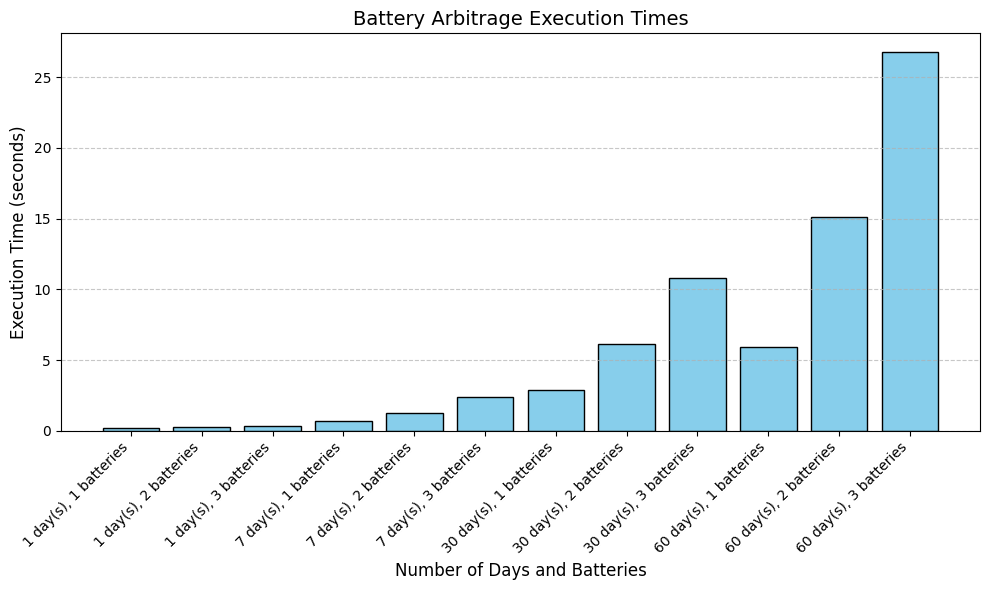

In [6]:
print(experiment_results)
plot_PSA_exec_time(experiment_results)
